# **Assignment:** 

You are required to develop an Python template for Bayesian inference based on the pymc and arviz functions. 
-  You should develop functions for EDA/transformation, 

- specifying prior and likelihood, 

- sampling and the ppc part (the functions which specify what you can do with the posterior distribution outputs).

- need to add more functions which I have not taught but still very useful. 

- explain all the outputs of the sampling process in detail. 

- try out ALL the relevant parameters of a Bayesian inference problem from your template. 

- Do a dry run of your template with 100 islands example and with the estimation of the linear regression parameters.

## **Import Libraries**

In [111]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
%precision 4
plt.style.use('ggplot')

np.random.seed(1234)
import pymc3 as pm
import scipy.stats as stats


from scipy.special import expit as logistic
import arviz as az
RANDOM_SEED = 58

import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

import logging
_logger = logging.getLogger("theano.gof.compilelock")
_logger.setLevel(logging.ERROR)

## **Dataset**

In [112]:
def make_islands(n, low=10, high=101):
    islands = np.random.randint(low, high, n+2)
    islands[0] = 0
    islands[-1] = 0
    return islands

def hop(islands, start=1, niter=1000):
    pos = start
    pop = islands[pos]
    thetas = np.zeros(niter+1, dtype='int')
    thetas[0] = pos
    for i in range(niter):
        # generate sample from proposal distribution
        k = np.random.choice([-1, 1], 1)
        next_pos = pos + k
        # evaluate unnormalized target distribution at proposed position
        next_pop = islands[next_pos]
        # calculate acceptance probability
        p = min(1, next_pop/pop)
        # use uniform random to decide accept/reject proposal
        if np.random.random() < p:
            pos = next_pos
            pop = next_pop
        thetas[i+1] = pos
    return thetas

def load_data(n):
  islands = make_islands(n)
  print("Islands: ",islands)
  thetas = hop(islands, start=1, niter=1000)
  print("Thetas: ", thetas)
  return islands, thetas

## **EDA**

In [113]:
def perform_eda(data):
  # data = islands[1:-1]
  # print(data)
  data = data/data.sum()
  sns.barplot(x=np.arange(len(data)), y=data)
  pass

def estimate_pop(data):
  data = np.bincount(thetas)[1:]
  mean = data.sum() / data.size
  print("True Mean: ", mean )
  data = data/data.sum()
  sns.barplot(x=np.arange(len(data)), y=data)
  pass

## **Sampling with NUTS**

In [114]:
def run_mcmc(model_, draws_, start_, tune_, parallel_chains,force_rerun=False):
  
  with model_:
    print('computing traces...')
    step = pm.NUTS() # Have a choice of samplers
    trace_ = pm.sample(
        draws=draws_,
        step=step,
        start = start_,
        tune=tune_,
        cores=parallel_chains,
        progressbar=True)
            
    print(pm.summary(trace_))
    return trace_

def run_ppc(model_, trace_, y_obs, thetas):
  with model_:
    
    forecast_1 = az.from_pymc3(
        posterior_predictive=pm.sample_posterior_predictive(trace=trace_))
    posterior_samples = forecast_1.posterior_predictive['y_obs'].values.flatten()

  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
  sns.countplot(x=thetas, color=sns_c[0], ax=ax[0])
  ax[0].set(title='Sample Distribution', xlabel='y', xlim=(-1, 10))
  sns.countplot(x=posterior_samples, color=sns_c[2], ax=ax[1])
  ax[1].set(title='Posterior Predictive Distribution', xlabel='y', xlim=(-1, 10));

  return forecast_1, posterior_samples

## **Plots**

In [115]:
def plots(trace):    
    # az.plot_trace(data=trace);
    az.summary(trace)
    
    #typical trace plots
    print("trace plot")
    pm.plot_trace(trace)
    
    #check if your posteriors look reasonable
    print("posterior plot")
    pm.plot_posterior(trace)
    
    # check if your variables have reasonable credible intervals, 
    #and Gelman–Rubin scores close to 1
    print("forest plot")
    pm.plot_forest(trace)
    
    #check if your chains are impaired by high autocorrelation. 
    #Also remember that thinning your chains is a waste of time at best, and deluding yourself at worst.
    print("autocorr plot")
    pm.plot_autocorr(trace)
    
    # ideally the energy and marginal energy distributions should look very similar. 
    # Long tails in the distribution of energy levels indicates deteriorated sampler efficiency.
    pm.energyplot(trace)

    # pm.plot_ppc(trace)

    #a souped-up version of pm.plot_posterior. 
    #It doesn’t seem to be wildly useful unless you’re plotting posteriors from multiple models.
    print("density plot")
    pm.plot_density(trace)
    
    # Display the total number and percentage of divergent chains
    # diverging = trace['diverging']
    # print('Number of Divergent Chains: {}'.format(diverging.nonzero()[0].size))
    # diverging_pct = diverging.nonzero()[0].size / len(trace) * 100
    # print('Percentage of Divergent Chains: {:.1f}'.format(diverging_pct))
    
    az.plot_pair(trace, 
                 var_names=['p','p'], 
                 kind='kde', 
                 group="posterior",
                 divergences=True,
                 colorbar=True,
                 divergences_kwargs={'color': 'C2'})

In [127]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

def prior_check(model_):
  N = 100
  true_a, true_b, predictor = 0.5, 3.0, np.random.normal(loc=2, scale=6, size=N)
  true_mu = true_a + true_b * predictor
  true_sd = 2.0
  outcome = np.random.normal(loc=true_mu, scale=true_sd, size=N)
  f"{predictor.mean():.2f}, {predictor.std():.2f}, {outcome.mean():.2f}, {outcome.std():.2f}"

  predictor_scaled = standardize(predictor)
  outcome_scaled = standardize(outcome)

  f"{predictor_scaled.mean():.2f}, {predictor_scaled.std():.2f}, {outcome_scaled.mean():.2f}, {outcome_scaled.std():.2f}"


  with model_:
    a1 = pm.Normal("a1", 0.0, 10.0)
    b1 = pm.Normal("b1", 0.0, 10.0)

    mu = a1 + b1 * predictor_scaled
    sd1 = pm.Exponential("sd1", 1.0)
    obs = pm.Normal("obs", mu=mu, sigma=sd1, observed=outcome_scaled)
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)


  _, ax = plt.subplots()
  x = np.linspace(-2, 2, 50)
  for a, b in zip(prior_checks["a1"], prior_checks["b1"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.4)

  ax.set_xlabel("Predictor (stdz)")
  ax.set_ylabel("Mean Outcome (stdz)")
  ax.set_title("Prior predictive checks -- Flat priors");


## **Estimating Parameters of the Linear Regression Model**

In [117]:
def fit_linear_model(model_):
  _a = 6
  _b = 2
  x = np.linspace(0, 1, 100)
  y = _a*x + _b + np.random.randn(100)

  with pm.Model() as linear_reg:
    a = pm.Normal('a', mu=0, sd=20)
    b = pm.Normal('b', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)

    y_est = a*x + b # simple auxiliary variables

    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
    
    # inference
    start = pm.find_MAP()
    step = pm.NUTS() # Hamiltonian MCMC with No U-Turn Sampler
    trace = pm.sample(1000, step, start, random_seed=123, progressbar=True)
    pm.traceplot(trace);
    print(pm.summary(trace))
    

## **Execution Starts**

Islands:  [  0  93  48  63  86  34  25  59  33  36  40  53  40  36  68  79  90  83
  57  60  86  47  44  48  77  21  10  85  90  13  12  29  22  75  85  91
  24  81  70  56  38  91  97  23  22  79  41  99  94  55  26  51  82  66
  80  66  96  54 100  93  57  59  28  95  56  47  48  17  77  15  57  57
  25  44  20  38  14  92  99  65  88  33  60  72  65  94  10 100  43  31
  81  78  91  62  74  95  51  11  24  13  40   0]
Thetas:  [ 1  2  3 ... 23 24 24]


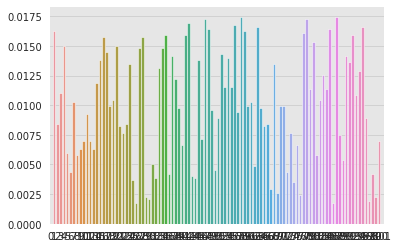

In [118]:
islands, thetas = load_data(100)

#Performing EDA
perform_eda(islands)

True Mean:  35.75


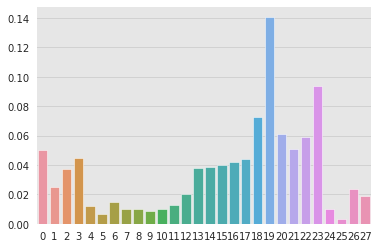

In [119]:
# Estimating population
estimate_pop(thetas)

## **Poisson Distribution**

computing traces...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.


     mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
p  37.172  0.193   36.84   37.533  ...    0.005     756.0    1524.0    1.0

[1 rows x 9 columns]


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


trace plot


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


posterior plot


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


forest plot


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


autocorr plot


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The function `energyplot` from PyMC3 is just an alias for `plot_energy` from ArviZ. Please switch to `pymc3.plot_energy` or `arviz.plot_energy`.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on conte

density plot


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/plots/pairplot.py:234: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats

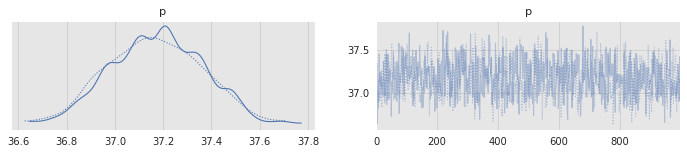

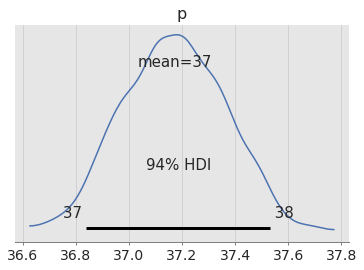

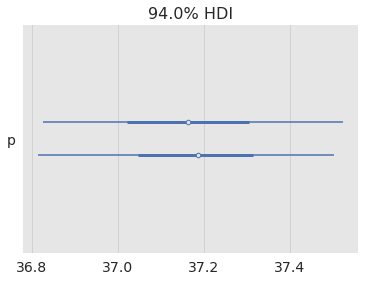

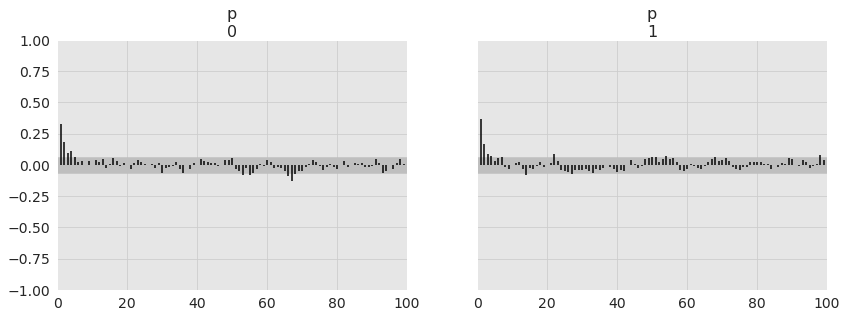

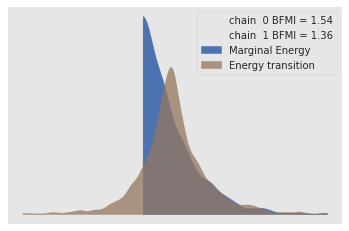

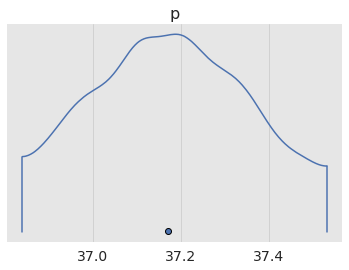

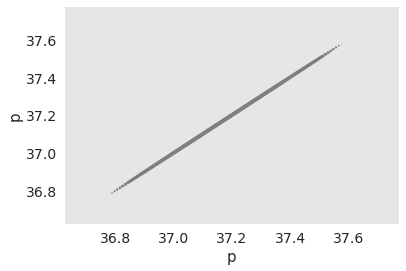

In [ ]:
# Parameters of the Poisson distribution.
a = 3 # shape
b = 1 # rate = 1/scale

with pm.Model() as my_model:

    # Define the prior of the parameter lambda.
    p = pm.Gamma('p', alpha=a, beta=b)

    # Define the likelihood function.
    y_obs = pm.Poisson('y_obs', mu=p, observed=thetas)
    start=None

trace = run_mcmc(my_model, draws_=1000, start=start, tune_=1000, parallel_chains=2,force_rerun=False)
plots(trace)

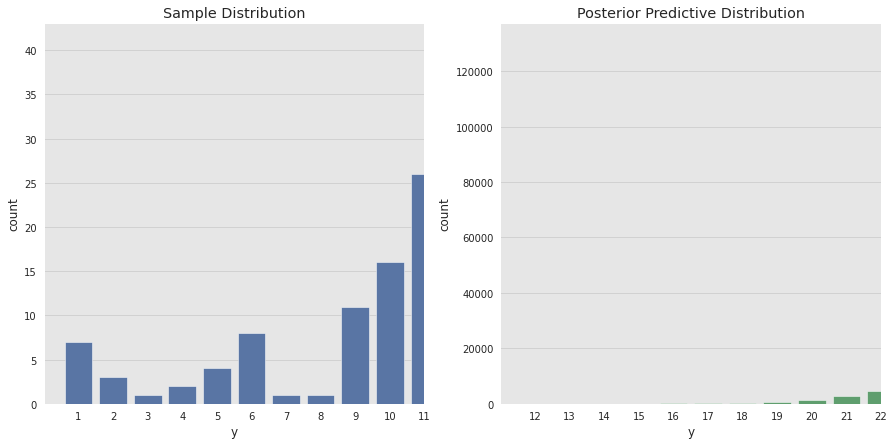

In [ ]:
f1 , ppc = run_ppc(my_model, trace,y_obs, thetas)

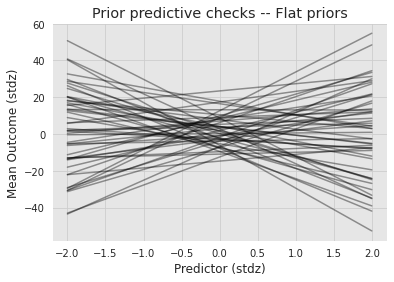

In [ ]:
# Flat Prior check
prior_check(my_model)

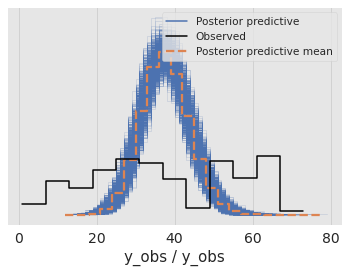

In [ ]:
az.plot_ppc(data=f1);

### **Results:** 

- The r_hat denotes the Gelman-Rubin test, which indicates convergence of the chains. Values close to 1.0 mean convergence.

- Traced Plot: Multi-modals are showing however there's a hope that it will converge to a normal distribution. 

- HDI: The HDI is the interval which contains the required mass such that all points within the interval have a higher probability density than points outside the interval. 94% HDI is good.

- Posterior Plot: shows good results as it is a Fuzzy caterpillar and the values are falling around the mean.

- Energy plot: In this plot we want the marginal and energy transition plots to overlap as much as possible. But the long tails in the distribution of energy levels indicating deteriorated sampler efficiency.

- The posterior predictive shows that the prediction is very low from real values.

- Flat Prior check: It is converging at 0 which is a good thing.
- PPC: The difference between observed and posterior/prior predictive data is clearly visible.


## **Univariate normal distribution**


computing traces...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if sys.path[0] == '':
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.


      mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
p   15.479  0.246  15.003   15.918  ...    0.004    1658.0    1408.0    1.0
sd   7.578  0.176   7.259    7.899  ...    0.003    1470.0    1351.0    1.0

[2 rows x 9 columns]


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


trace plot


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


posterior plot


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


forest plot


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


autocorr plot


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The function `energyplot` from PyMC3 is just an alias for `plot_energy` from ArviZ. Please switch to `pymc3.plot_energy` or `arviz.plot_energy`.
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on conte

density plot


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/plots/pairplot.py:234: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats

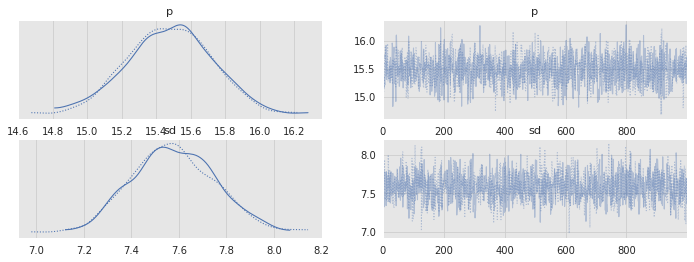

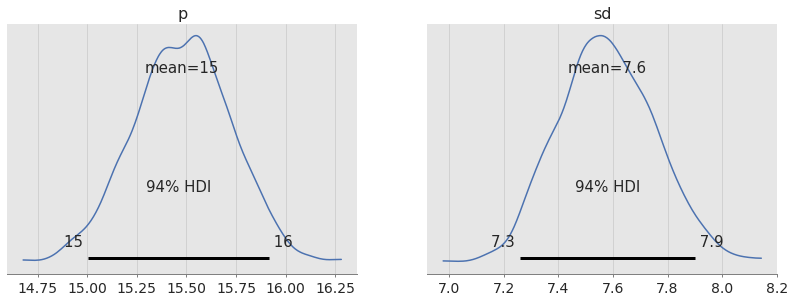

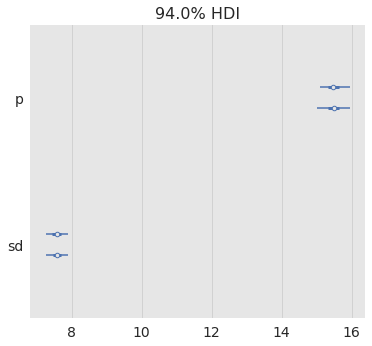

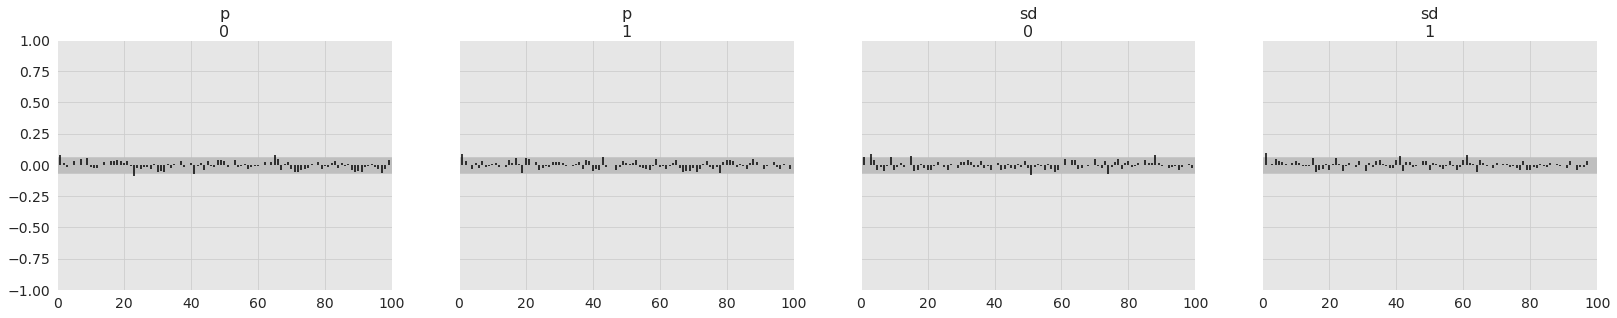

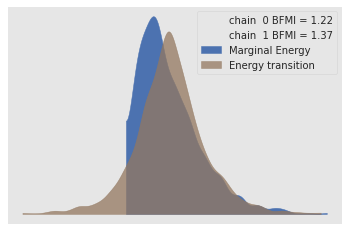

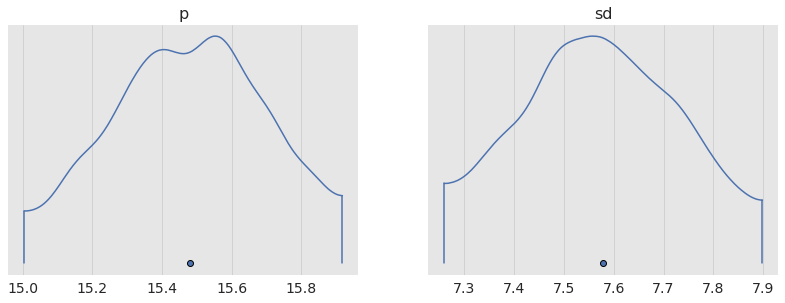

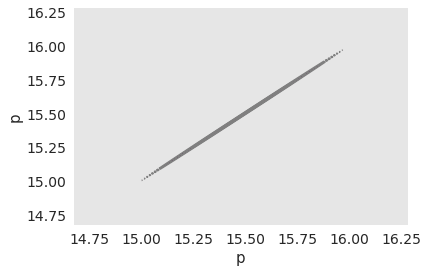

In [121]:
# Parameters of the Normal distribution.
with pm.Model() as n_model:
  p = pm.Normal('p', mu=0, sd=1)
  sd = pm.HalfCauchy('sd', beta=2)
  y = pm.Normal('y_obs', mu=p, sd=sd, observed=thetas)
  start = pm.find_MAP()

n_trace = run_mcmc(n_model, draws_=1000, start_=start, tune_=1000, parallel_chains=2,force_rerun=False)
plots(n_trace)

In [122]:
# n_f1 , n_ppc = run_ppc(n_model, n_trace, y, thetas)

with n_model:
    forecast_1 = az.from_pymc3(posterior_predictive=pm.sample_posterior_predictive(trace=n_trace))
    posterior_samples = forecast_1.posterior_predictive['y_obs'].values.flatten()
print(posterior_samples)

[24.0286 20.2188 17.9983 ... 14.2231 28.4398 24.6519]


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
sns.countplot(x=thetas, color=sns_c[0], ax=ax[0])
ax[0].set(title='Sample Distribution', xlabel='y', xlim=(-1, 10))
sns.countplot(x=posterior_samples, color=sns_c[2], ax=ax[1])
ax[1].set(title='Posterior Predictive Distribution', xlabel='y', xlim=(-1, 10));

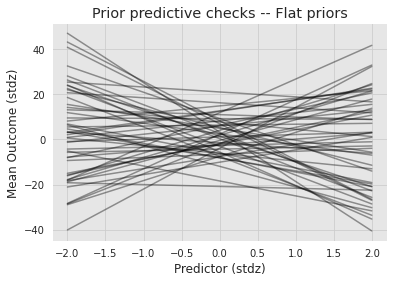

In [128]:
# Flat Prior check
prior_check(n_model)

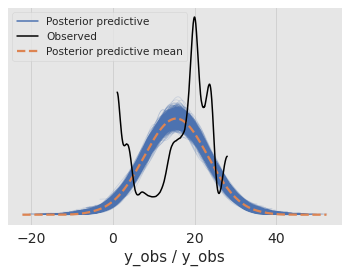

In [124]:
az.plot_ppc(data=forecast_1);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8893131977098444, but should be close to 0.8. Try to increase the number of tuning steps.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.


        mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
a      5.542  0.352   4.888    6.186  ...    0.009     767.0     854.0   1.01
b      2.067  0.202   1.719    2.483  ...    0.005     799.0     785.0   1.00
sigma  0.969  0.069   0.849    1.107  ...    0.001    1100.0    1106.0   1.01

[3 rows x 9 columns]


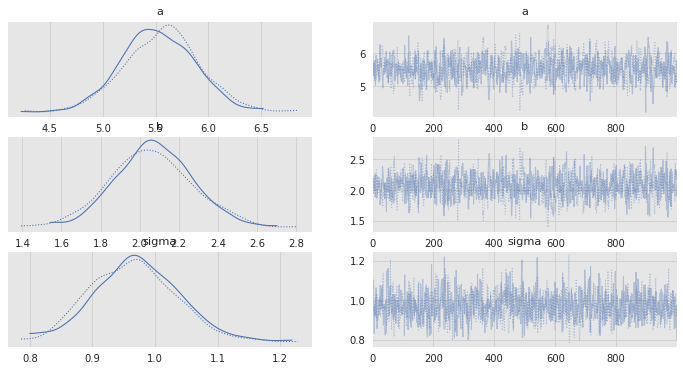

In [ ]:
fit_linear_model(n_model)

### **Results:** 

- The r_hat denotes the Gelman-Rubin test, which indicates convergence of the chains. Values close to 1.0 mean convergence.

- Traced Plot: The plot is showing an almos normal distribution. 

- HDI: The HDI is the interval which contains the required mass such that all points within the interval have a higher probability density than points outside the interval. 94% HDI is good.

- Posterior Plot: shows good results as it is a Fuzzy caterpillar and the values are falling around the mean.

- Energy plot: In this plot we want the marginal and energy transition plots to overlap as much as possible. This is better then poisson outcome.

- The posterior predictive shows that the prediction is very low from real values.

- Flat Prior check: Not all values are converging a point 0.
- PPC: The difference between observed and posterior/prior predictive data is clearly visible. The observed value are entirely different.

- Linear Regression Model: It is also showing good results as the values are not far from what was observed.